<a href="https://colab.research.google.com/github/munich-ml/MLPy2021/blob/main/15_Logfiles_w_Pandas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Logfile challenge

## setup

The setup depends on whether the notebook is executed in **Google Colab** or **locally in Jupyter**.

- Clone GitHub project `MLPy2021` if executed in Colab
- import `parse_logfile_string` from `helper_funcs`
- open file `logfile.csv` and store content into variable `s`



In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

in_colab = 'google.colab' in sys.modules   # check if note is executed within Colab

# Clone the repository if executed in Google Colab
if in_colab:  
    if "MLPy2021" in os.listdir():
        !git -C MLPy2021 pull
    else:
        !git clone https://github.com/munich-ml/MLPy2021/

# The function `parse_logfile_string` from 10_Logfile_challenge.ipynb has been moved 
# lib.helper_funcs.py. The import path depends on Colab or local execution 
if in_colab:
    from MLPy2021.lib.helper_funcs import parse_logfile_string
else:
    from lib.helper_funcs import parse_logfile_string

# Reading the logfile.csv content into the <st> variable s
# The import path depends on Colab or local execution 
if in_colab:
    filename = os.path.join("MLPy2021", "datasets", "logfile.csv")
else:
    filename = os.path.join("datasets", "logfile.csv")

with open(filename, "r") as file:
    s = file.read()

# Reuse functions from **NumPy** session



In [2]:
def apply_calibration(log):
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            col_index = log["names"].index(sig)

            # append the new column with calibrated data to the right
            new_col = log["data"][:, col_index] * float(cal_factor)
            log["data"] = np.column_stack([log["data"], new_col])

            # also add the new name to the names list
            log["names"].append(sig + "_cal") 

In [3]:
def plot(log, sig_names):
    x = log["data"][:, log["names"].index("x")]
    for sig_name in sig_names:
        if sig_name in log["names"]:
            y = log["data"][:, log["names"].index(sig_name)]
            plt.plot(x, y, "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend(), plt.tight_layout()

In [4]:
def parse_logfile_string_to_numpy(s):
    """
    Wraps 'parse_logfile_string' function and converts the "data" list of lists to an NumPy array
    """
    log_dict = parse_logfile_string(s)
    log_dict["data"] = np.array(log_dict["data"])
    return log_dict

In [5]:
log = parse_logfile_string_to_numpy(s)

print("data head before calibration:")
print(log["names"])
print(log["data"][:3, :])

apply_calibration(log)

print("data head after calibration:")
print(log["names"])
print(log["data"][:3, :])

data head before calibration:
['x', 'sig0', 'sig1', 'sig2']
[[ 5.17   6.4   16.05  10.61 ]
 [ 9.47  34.21   5.95   0.293]
 [ 7.65  21.11   0.366  4.8  ]]
data head after calibration:
['x', 'sig0', 'sig1', 'sig2', 'sig0_cal', 'sig2_cal']
[[ 5.17     6.4     16.05    10.61     3.52    19.9468 ]
 [ 9.47    34.21     5.95     0.293   18.8155   0.55084]
 [ 7.65    21.11     0.366    4.8     11.6105   9.024  ]]


Warning, 'sig1_cal' is not in 'log['names']'!
Warning, 'sig42' is not in 'log['names']'!


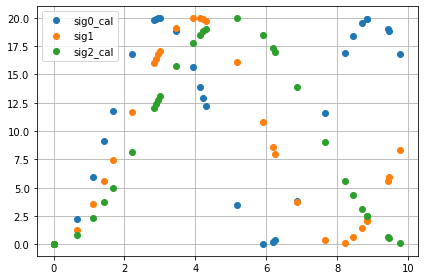

In [6]:
plot(log, sig_names=["sig0_cal", "sig1_cal", "sig1", "sig42", "sig2_cal"])

... the NumPy version still works.

Next, lets introduce **Pandas**...

# Exercise df creation
- Create a `parse_logfile_string_to_pandas` that returns `data` and `names` are in a `Pandas.DataFrame`


## Solution

In [7]:
def parse_logfile_string_to_pandas(s):
    """
    Wraps 'parse_logfile_string' function and converts the "data" list of lists to a Pandas DataFrame
    """
    log = parse_logfile_string(s)
    df = pd.DataFrame(np.array(log["data"]), columns=log["names"])
    return {"data": df.set_index("x"),
            "params": pd.Series(log["params"], name="params")}

## Testing `parse_logfile_string_to_pandas` 

In [8]:
log = parse_logfile_string_to_pandas(s)
log["data"].head()

,sig0,sig1,sig2
x,,,
5.17,6.40,16.050,10.610
9.47,34.21,5.950,0.293
7.65,21.11,0.366,4.800
2.82,36.06,16.030,6.390
2.21,30.50,11.650,4.360


In [9]:
log["params"]

measurement date           2021-04-06
measurement time             08:00:00
calibration factor sig0          0.55
calibration factor sig2          1.88
Name: params, dtype: object

# Exercise df calculations
- Rework the `apply_calibration` function to accept the new `DataFrame`
- The predecessors implementation with NumPy support is given below for reference


In [10]:
# predecessor NumPy version
def apply_calibration(log):
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            col_index = log["names"].index(sig)

            # append the new column with calibrated data to the right
            new_col = log["data"][:, col_index] * float(cal_factor)
            log["data"] = np.column_stack([log["data"], new_col])

            # also add the new name to the names list
            log["names"].append(sig + "_cal") 

## Solution

In [11]:
def apply_calibration(log):
    for param, cal_factor in log["params"].items():
        if "calibration factor" in param:
            sig = param.split(" ")[-1]
            log["data"][sig + "_cal"] = log["data"][sig] * float(cal_factor)

## Testing `apply_calibration` 

In [12]:
apply_calibration(log)
log["data"].head()

,sig0,sig1,sig2,sig0_cal,sig2_cal
x,,,,,
5.17,6.40,16.050,10.610,3.5200,19.94680
9.47,34.21,5.950,0.293,18.8155,0.55084
7.65,21.11,0.366,4.800,11.6105,9.02400
2.82,36.06,16.030,6.390,19.8330,12.01320
2.21,30.50,11.650,4.360,16.7750,8.19680


# Exercise df plot
- Rework the `plot` function to accept the new `DataFrame`
- The predecessors implementation with NumPy support is given below for reference
- As an extra feature, make ``sig_names`` an optional parameter and plot all signals if ``sig_names`` is not provided 


In [13]:
# predecessor NumPy version
def plot(log, sig_names):
    x = log["data"][:, log["names"].index("x")]
    for sig_name in sig_names:
        if sig_name in log["names"]:
            y = log["data"][:, log["names"].index(sig_name)]
            plt.plot(x, y, "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend()

## Solution

In [14]:
def plot(log, sig_names=None):
    df = log["data"]
    if sig_names is None:
        sig_names = df.columns
    for sig_name in sig_names:        
        if sig_name in df.columns:
            plt.plot(df.index, df[sig_name], "o", label=sig_name)
        else:
            print("Warning, '{}' is not in 'log['names']'!".format(sig_name))
    plt.grid(), plt.legend()

## Testing `plot` 

Warning, 'sig1_cal' is not in 'log['names']'!
Warning, 'sig42' is not in 'log['names']'!


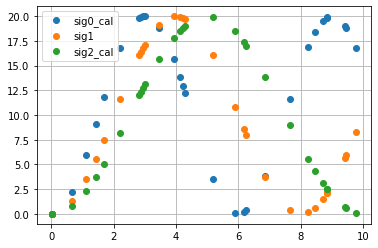

In [15]:
plot(log, sig_names=["sig0_cal", "sig1_cal", "sig1", "sig42", "sig2_cal"])

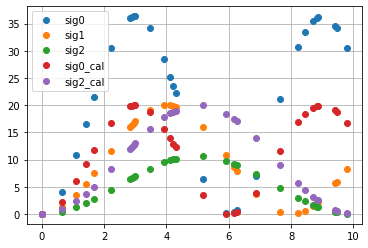

In [16]:
plot(log)